<a id='top'></a>
<h1 style="text-align:center;font-size:220%;;">Predire si un tweet annonce une réelle catastrophe ou pas</h1>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRI1s5Yl_ker0QrrQZATPbLwiKJJ8RgkCarpvW4GoAf5sFdYZE3&usqp=CAU">

- ***Abou DIENG***
- ***Sidi DOUMBOUYA***  

# I. Description du projet

Twitter est devenu un canal de communication important en cas d'urgence. L'omniprésence des smartphones permet aux gens d'annoncer une urgence qu'ils observent en temps réel. C'est pourquoi de plus en plus d'agences s'intéressent à la surveillance programmatique de Twitter (c'est-à-dire les organisations de secours en cas de catastrophe et les agences de presse).
Mais il n'est pas toujours évident de savoir si les paroles d'une personne annoncent réellement une catastrophe.
Ici, notre objectif est de prédire quels Tweets concernent de vraies catastrophes et lesquels n'en sont pas. 

Chaque échantillon dans le train et le test contient les informations suivantes :

- **Id** : un identifiant unique pour chaque tweet
- **Text** : le texte du tweet
- **Location** : l'endroit d'où le tweet a été envoyé (peut être vide)
- **Keyword** : un mot-clé particulier du tweet (peut être vide)
- **Target** : indique si un tweet porte sur une véritable catastrophe (1) ou non (0)


### importatons librairies

In [49]:
import pandas as pd
import spacy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
import seaborn as sns
import re
import spacy.cli
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import time
from sklearn.metrics import classification_report,confusion_matrix

#### Lecture des données

In [50]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [51]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# II. Data Exploration

### Figure 1 : Comparaison entre tweet catastrophe et pas catastrophe

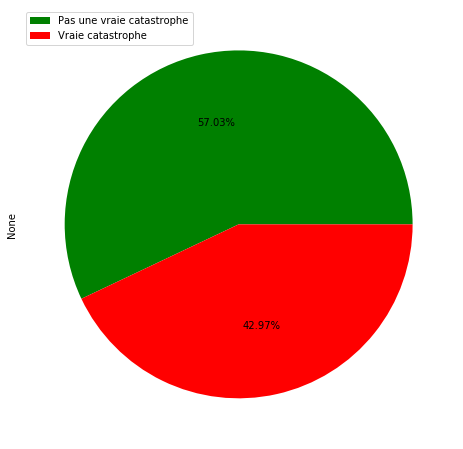

In [52]:
target_names = ["Pas une vraie catastrophe", "Vraie catastrophe"]

color = ["g", "r"]

plt.figure(figsize=(12, 8))
train.groupby("target").size().sort_values(ascending=False).plot(kind="pie", autopct="%.2f%%", labels=None, colors=color)
plt.legend(target_names, loc='upper left')
print()

La figure 1 montre que la proportion des tweets qui annoncent un réel catastrophe réprensente 57%.

### Figure 2 : Top 20 des mots clés les plus courants par catégorie

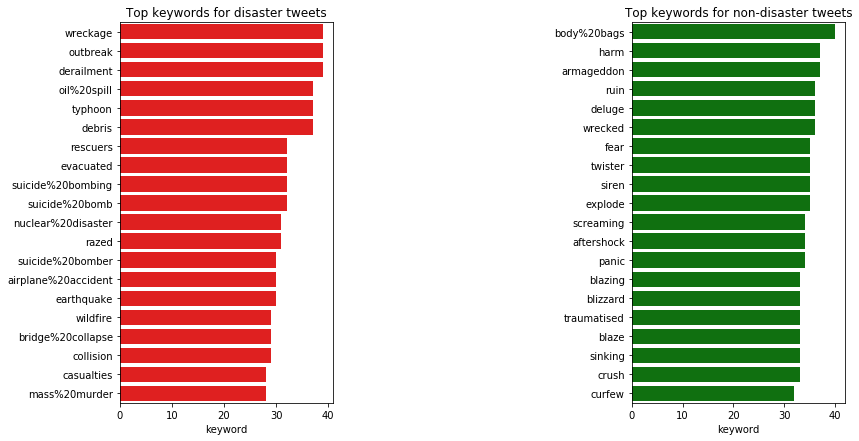

In [53]:
kw_d = train[train.target==1].keyword.value_counts().head(20)
kw_nd = train[train.target==0].keyword.value_counts().head(20)

plt.figure(figsize=(13,7))

plt.subplot(131)
sns.barplot(kw_d, kw_d.index, color='r')
plt.title('Top keywords for disaster tweets')

plt.subplot(133)
sns.barplot(kw_nd, kw_nd.index, color='g')
plt.title('Top keywords for non-disaster tweets')

plt.show()

### Figure 3 : Top 10 des lieux les plus courants d'où ont été envoyés les tweets

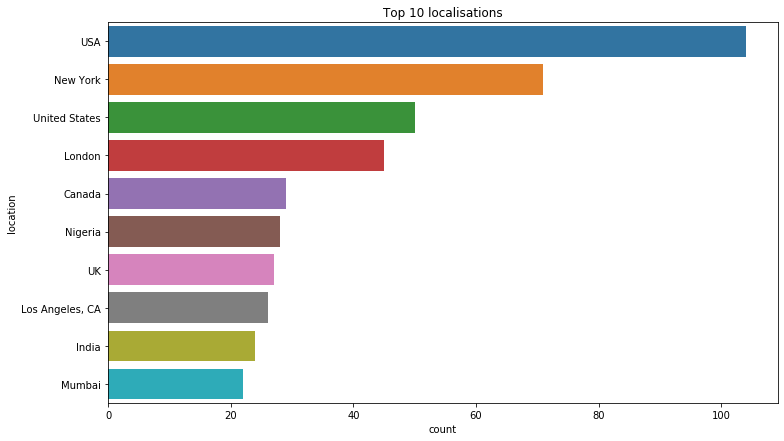

In [54]:
# Lieux les plus courants
plt.figure(figsize=(12,7))
sns.countplot(y=train.location, order = train.location.value_counts().iloc[:10].index)
plt.title('Top 10 localisations')
plt.show()

La figure ci-dessus montre que la majorité des tweets proviennent des USA, suivis du UK (london), du Canada et du Nigeria.

# III. Data cleaning 

In [55]:
test_str = train.loc[417, 'text']

def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text

print("Original text: " + test_str)
print("Cleaned text: " + clean_text(test_str))

Original text: Arson suspect linked to 30 fires caught in Northern California http://t.co/mmGsyAHDzb
Cleaned text: Arson suspect linked to 30 fires caught in Northern California


In [56]:
def find_hashtags(tweet):
     return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    return df
    
train = process_text(train)
test = process_text(test)

In [57]:
train.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...


In [58]:
text = train["text_clean"]

In [59]:
join_text = "".join(text)

In [60]:
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [61]:
doc = nlp(join_text)

In [62]:
# Visualisation du texte:
#print(doc) 

### Figure 4 : Le nuage mots

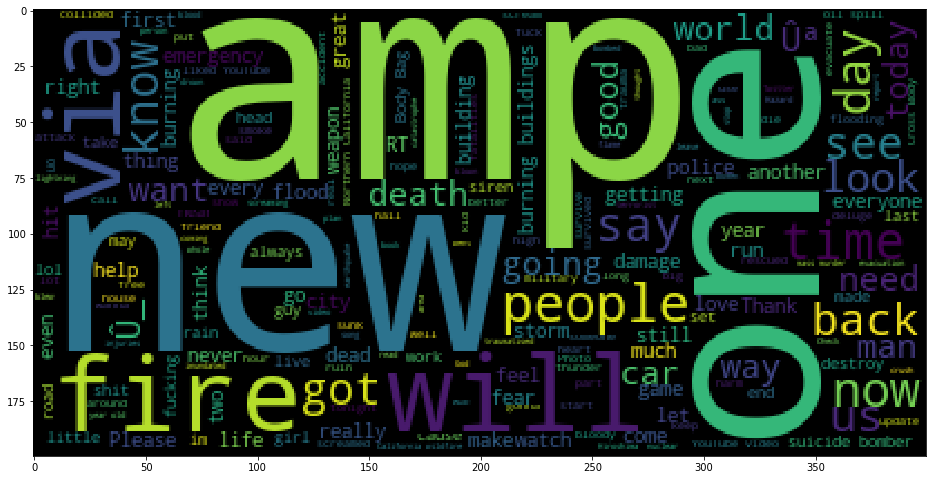

In [63]:
wd = wordcloud.WordCloud()
cloud = wd.generate(doc.text)
plt.figure(figsize = (16, 10))
plt.imshow(cloud)
print()

### Tokenization

In [64]:
# Création d'un set() qui va prendre tous les tokens unique de notre corpus de texte
tokens = [token.text for token in doc]
vocabulary_set= set(tokens)
vocab_size = len(vocabulary_set)
print(vocab_size)

24187


In [65]:
embedding_dim = 32

# Max number of words in each complaint.
max_length = 20
trunc_type='post'
padding_type='post'

# oov_took its set for words out our word index
oov_tok = "<XXX>"
training_size = 6090
seq_len = 12

In [66]:
# this is base in 80% of the data, an only text and target at this moment

training_sentences = train.text[0:training_size]
training_labels = train.target[0:training_size]

testing_sentences = train.text[training_size:]
testing_labels = train.target[training_size:]

In [67]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [68]:
training_padded[1628]

array([9508, 9509, 2310, 9510, 3489, 2309, 1433,  130,  425, 2309, 1433,
        130,  425, 3489,    4,    2,    3, 9511, 9512,    0])

In [69]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# IV. Création du modèle

In [70]:
# Model Definition with LSTM

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64, input_length=20),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Conv1D(16, 3, activation="relu"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # remember this is a binary clasification
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [71]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 64)            1547968   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 20, 128)           66048     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 18, 16)            6160      
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               41472     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 16)               

In [72]:
thresholds=0.50
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]

In [73]:
# Création d'un schedule learning rate 
initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=500,
    decay_rate=0.96,
    staircase=True)

# Création d'un compileur
model.compile(optimizer = tf.keras.optimizers.Adam(lr_schedule),
              loss= tf.keras.losses.binary_crossentropy,
              metrics = [METRICS])

In [74]:
%%time
num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
6090/6090 [==============================] - 28s 5ms/sample - loss: 0.6609 - accuracy: 0.5893 - precision: 0.8280 - recall: 0.0301 - auc: 0.6101 - val_loss: 0.6394 - val_accuracy: 0.6126 - val_precision: 0.9407 - val_recall: 0.1791 - val_auc: 0.7816
Epoch 2/10
6090/6090 [==============================] - 16s 3ms/sample - loss: 0.4860 - accuracy: 0.7916 - precision: 0.8212 - recall: 0.6452 - auc: 0.8439 - val_loss: 0.4901 - val_accuracy: 0.7735 - val_precision: 0.8383 - val_recall: 0.6361 - val_auc: 0.8358
Epoch 3/10
6090/6090 [==============================] - 16s 3ms/sample - loss: 0.3092 - accuracy: 0.8760 - precision: 0.8951 - recall: 0.7990 - auc: 0.9350 - val_loss: 0.4946 - val_accuracy: 0.7643 - val_precision: 0.7472 - val_recall: 0.7461 - val_auc: 0.8399
Epoch 4/10
6090/6090 [==============================] - 14s 2ms/sample - loss: 0.1994 - accuracy: 0.9307 - precision: 0.9385 - recall: 0.8938 - auc: 0.9707 - val_loss: 0

In [75]:
model_loss = pd.DataFrame(model.history.history)
model_loss

,loss,accuracy,precision,recall,auc,val_loss,val_accuracy,val_precision,val_recall,val_auc
0,0.660922,0.589327,0.827957,0.030055,0.610078,0.639385,0.612607,0.940741,0.179126,0.781623
1,0.485981,0.791626,0.821162,0.645199,0.843882,0.490132,0.773473,0.838290,0.636107,0.835767
2,0.309185,0.876026,0.895059,0.798985,0.935032,0.494558,0.764281,0.747175,0.746121,0.839879
3,0.199357,0.930706,0.938525,0.893833,0.970679,0.568859,0.776756,0.790551,0.708039,0.839310
4,0.129345,0.957143,0.962978,0.934036,0.986496,0.673072,0.759685,0.764253,0.699577,0.828773
5,0.088258,0.970279,0.973360,0.955504,0.993455,0.695651,0.742613,0.701398,0.778561,0.826976
6,0.062003,0.981117,0.982643,0.972287,0.996225,0.814351,0.722915,0.672269,0.789845,0.816789
7,0.049148,0.985057,0.986609,0.977752,0.997864,0.882730,0.764281,0.778662,0.689704,0.820878
8,0.037398,0.988834,0.987872,0.985558,0.998456,0.882364,0.757058,0.753363,0.710860,0.818826
9,0.035364,0.988506,0.989011,0.983607,0.998625,0.942005,0.751149,0.750760,0.696756,0.811338


### Figure 5 : Visualisation train / Valid Accuracy

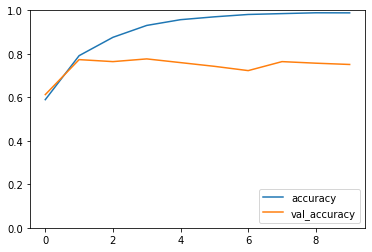

In [76]:
model_loss[['accuracy','val_accuracy']].plot(ylim=[0,1])
plt.legend(loc='lower right')
print()

# V. Evaluation du modèle

In [77]:
predictions = model.predict_classes(testing_padded)   # predict_ clases because is classification problem with the split test

In [78]:
predictions

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

### Figure 6 : matrice de confusion

In [79]:
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

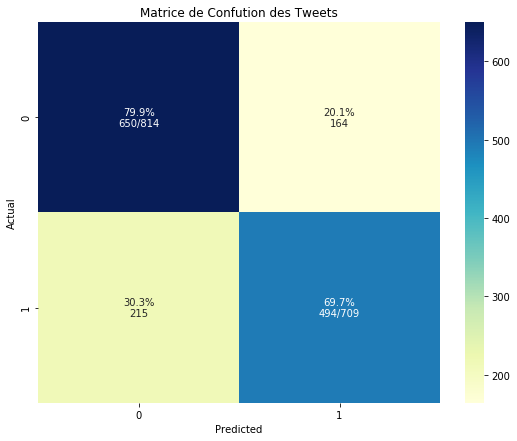

In [80]:
plot_cm(testing_labels,predictions, 'Matrice de Confution des Tweets', figsize=(9,7))

- La matrice de confusion revèle des resultats intéressants. Ainsi, a chaque fois que le modèle predit qu'un tweet n'annonce pas une réelle catastrophe, cela se verifie à près de 80%. A l'inverse lorsqu'on predit qu'un tweet annonce une reelle catastrophe, il se trompe à 30%. Ce dernier résultat contient un taux d'erreur relativement élevé. Notre modèle reste donc à améliorer.  